# Fraud Detection </font>
Clémence Grocholska - 9th of July 2024

### <font color='BLUE'>  Project objective </font>
Develop an anti-Fraud model 

### <font color='BLUE'>  Source Dataset </font>
PAYSIM
Fraud detection research in financial services, especially mobile money, faces a data gap due to the privacy of financial transactions. The PaySim simulator addresses this by creating synthetic datasets that mimic real-world mobile money transactions. It uses aggregated data from private sources to simulate regular activity and inject fraudulent behavior, allowing researchers to test fraud detection methods without risking sensitive information.
PaySim is based on a sample of real mobile money transactions from an African country, provided by a multinational company with services in over 14 countries. This synthetic approach provides a valuable resource for advancing fraud detection research.
step: A unit of time representing one hour in the real world. The total number of steps is 744, corresponding to a 30-day simulation. [Source dataset on Kaggle: https://www.kaggle.com/code/anuragbelel/analyzing-financial-transactions]

type: The type of transaction. The possible types are CASH-IN, CASH-OUT, DEBIT, PAYMENT, and TRANSFER.

- amount: The transaction amount in local currency.
- nameOrig: The customer who initiated the transaction.
- oldbalanceOrg: The initial balance of the customer before the transaction.
- newbalanceOrig: The new balance of the customer after the transaction.
- nameDest: The recipient of the transaction.
- oldbalanceDest: The initial balance of the recipient before the transaction. There is no information for customers whose names start with "M" (indicating merchants).
- newbalanceDest: The new balance of the recipient after the transaction. As with "oldbalanceDest," there is no information for customers whose names start with "M."
- isFraud: Indicates whether a transaction is fraudulent. In this dataset, fraudulent behavior involves gaining control of customer accounts, attempting to transfer funds to another account, and then cashing out.
 -isFlaggedFraud: Flags transactions that exceed a certain threshold. In this dataset, transfers over 200,000 in a single transaction are flagged as potentially fraudulent.

### <font color='BLUE'>  0. First parameters </font>

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import datetime
import matplotlib.pyplot as plt
import math

%matplotlib inline

# plt.rcParams['figure.figsize'] = (8, 6)
# plt.rcParams['font.size'] = 14
plt.style.use("seaborn-v0_8")

In [37]:
# !pip install seaborn --upgrade

  Obtaining dependency information for seaborn from https://files.pythonhosted.org/packages/83/11/00d3c3dfc25ad54e731d91449895a79e4bf2384dc3ac01809010ba88f6d5/seaborn-0.13.2-py3-none-any.whl.metadata
   ---------------------------------------- 0.0/294.9 kB ? eta -:--:--
   - -------------------------------------- 10.2/294.9 kB ? eta -:--:--
   -------- ------------------------------- 61.4/294.9 kB 1.1 MB/s eta 0:00:01
   ---------------------------------------- 294.9/294.9 kB 3.0 MB/s eta 0:00:00
  Attempting uninstall: seaborn
    Found existing installation: seaborn 0.12.2
    Uninstalling seaborn-0.12.2:
      Successfully uninstalled seaborn-0.12.2


### <font color='BLUE'> 1. Read the transaction file and check content </font>

In [2]:
# import data
df=pd.read_csv("transactions_log.csv")
df.sample(5)


,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
4679810,331,CASH_OUT,76599.39,C229841494,0.0,0.00,C797723650,119224.67,195824.05,0,0
4190731,305,CASH_OUT,174365.31,C678318659,0.0,0.00,C1772041869,1381472.15,1555837.47,0,0
1369735,138,CASH_IN,145706.74,C1432257368,72633.0,218339.74,C1922453789,4442583.81,5806267.81,0,0
1082082,129,CASH_OUT,92783.67,C1541434034,0.0,0.00,C643851230,353806.73,795742.81,0,0
3645358,275,PAYMENT,10039.62,C1878364390,25015.0,14975.38,M319256770,0.00,0.00,0,0


In [3]:
print(df.shape)
print(df.info())

(6362620, 11)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB
None


In [4]:
df.nunique().to_frame('number of unique values')


,number of unique values
step,743
type,5
amount,5316900
nameOrig,6353307
oldbalanceOrg,1845844
newbalanceOrig,2682586
nameDest,2722362
oldbalanceDest,3614697
newbalanceDest,3555499
isFraud,2


In [7]:
print(df.isnull().sum())

step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64


In [5]:
df.duplicated().any()

False

In [6]:
df_d=df.describe().copy()
df_d["step"]=df_d["step"].map('{:,.0f}'.format)

for col in ("amount","oldbalanceOrg","newbalanceOrig","oldbalanceDest","newbalanceDest"):
    df_d[col]=(df_d[col].astype(int) / 1000).round(0).astype(int)
    # df_d[col]=(df_d[col].astype(float) / 1000).round(3)
    # df_d=df_d.map('{:,.0f}'.format)
    df_d[col]=df_d[col].map('{:,}'.format)
    df_d[col] = df_d[col].astype(str) + " K"

df_d.drop(["count", "std"]).drop(columns=["isFraud","isFlaggedFraud"])

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest
mean,243,180 K,834 K,855 K,"1,101 K","1,225 K"
min,1,0 K,0 K,0 K,0 K,0 K
25%,156,13 K,0 K,0 K,0 K,0 K
50%,239,75 K,14 K,0 K,133 K,215 K
75%,335,209 K,107 K,144 K,943 K,"1,112 K"
max,743,"92,446 K","59,585 K","49,585 K","356,016 K","356,179 K"


In [10]:
# what are the metrics for fraud transactions
df_d=df[df["isFraud"]==1].describe().copy()
df_d["step"]=df_d["step"].map('{:,.0f}'.format)

for col in ("amount","oldbalanceOrg","newbalanceOrig","oldbalanceDest","newbalanceDest"):
    df_d[col]=(df_d[col].astype(int) / 1000).round(0).astype(int)
    # df_d=df_d.map('{:,.0f}'.format)
    df_d[col]=df_d[col].map('{:,}'.format)
    df_d[col] = df_d[col].astype(str) + " K"

df_d.drop(["count", "std"]).drop(columns=["isFraud","isFlaggedFraud"])

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest
mean,368,"1,468 K","1,650 K",192 K,544 K,"1,280 K"
min,1,0 K,0 K,0 K,0 K,0 K
25%,181,127 K,126 K,0 K,0 K,0 K
50%,367,441 K,439 K,0 K,0 K,5 K
75%,558,"1,518 K","1,518 K",0 K,148 K,"1,059 K"
max,743,"10,000 K","59,585 K","49,585 K","236,231 K","236,726 K"


In [11]:
quantile_90 = df[df["isFraud"]==1]['amount'].quantile(0.9)
quantile_90

4521723.512000004

In [18]:
quantile_05 = df[df["isFraud"]==1]['amount'].quantile(0.05)
quantile_05

17484.29

In [15]:
dff=df[df['amount']<=4521724]
df_b2=dff[dff["isFraud"]==1].describe().copy()

df_b2["amount"]=(df_b2["amount"].astype(int) / 1000).round(0).astype(int)
    # df_d=df_d.map('{:,.0f}'.format)
df_b2["amount"]=df_b2["amount"].map('{:,}'.format)
df_b2["amount"] = df_b2["amount"].astype(str) + " K"



In [16]:
df_b2["amount"] 

count        7 K
mean       754 K
std        947 K
min          0 K
25%        111 K
50%        349 K
75%      1,022 K
max      4,505 K
Name: amount, dtype: object

In [73]:
del df_d

#### <font color='#FF0000'> Note </font>
To avoid the Simpson's paradox, it is recommended to analyse different transaction amount categories separately. Otherwise, the amount variable may dominate the model, preventing other important variables from being selected in predicting fraud.

We decide to keep transactions of over 10K - done in section 2.3

#### <font color='BLUE'> Check the Fraud Indicator </font>

In [11]:
fraud_counts = df['isFraud'].value_counts()
total_count = len(df)

fraud_data = pd.DataFrame({'Count': fraud_counts, 'Percentage': fraud_counts / total_count * 100})

fraud_data

,Count,Percentage
isFraud,,
0,6354407,99.870918
1,8213,0.129082


#### <font color='#4682B4'> Note </font>
With such a low target rate, we will have to check if models where data imbalence is corrected are more performant

### <font color='BLUE'> 2. Assess the relevance of categorical value </font>

#### <font color='BLUE'> 2.1. Indicator Type </font>

In [13]:
tab_type1=pd.crosstab(df["type"],df["isFraud"])
print('Contingency Table for Type:\n',tab_type1)

print()
tab_type2 = pd.crosstab(df['type'], df['isFraud'], normalize='index') * 100
tab_type2['Total'] = 100
print(tab_type2.to_string())

print()
tab_flag1=pd.crosstab(df["isFlaggedFraud"],df["isFraud"])
print('Contingency Table for Illegal transactions vs Fraud:\n',tab_flag1)


Contingency Table for Type:
 isFraud         0     1
type                   
CASH_IN   1399284     0
CASH_OUT  2233384  4116
DEBIT       41432     0
PAYMENT   2151495     0
TRANSFER   528812  4097

isFraud            0         1  Total
type                                 
CASH_IN   100.000000  0.000000    100
CASH_OUT   99.816045  0.183955    100
DEBIT     100.000000  0.000000    100
PAYMENT   100.000000  0.000000    100
TRANSFER   99.231201  0.768799    100

Contingency Table for Illegal transactions vs Fraud:
 isFraud               0     1
isFlaggedFraud               
0               6354407  8197
1                     0    16


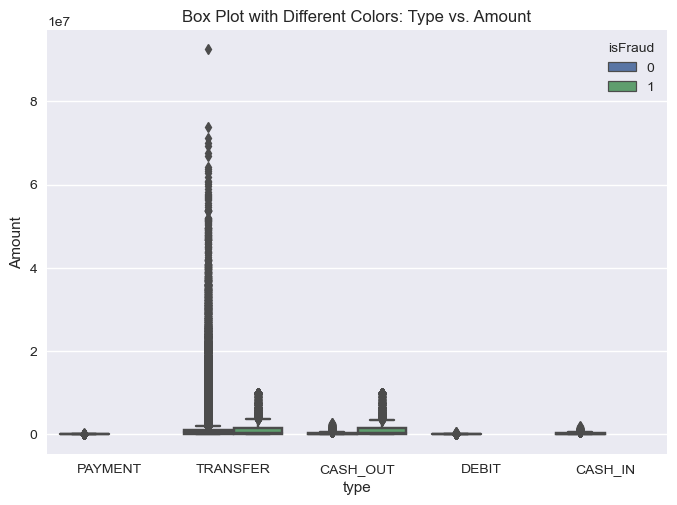

In [14]:
# Box Plot with different colors for each category
sns.boxplot(x='type', y='amount', data=df, hue='isFraud')
plt.xlabel('type')
plt.ylabel('Amount')
plt.title('Box Plot with Different Colors: Type vs. Amount')
plt.show()

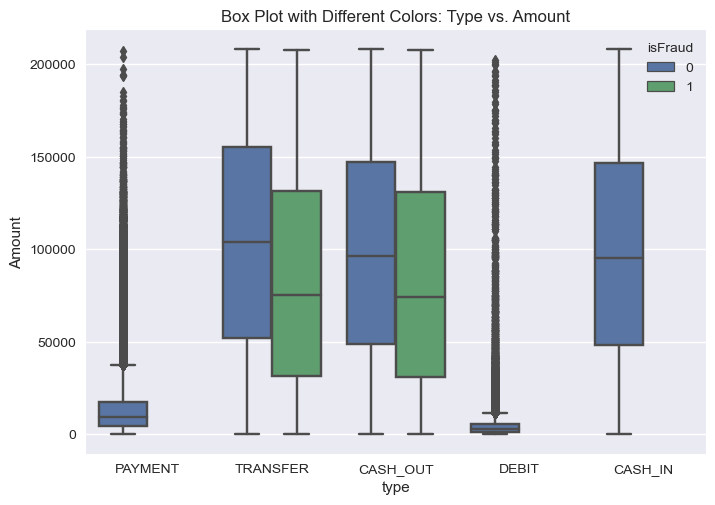

In [15]:
df_b=df[df['amount']<=208000]
# Box Plot with different colors for each category
sns.boxplot(x='type', y='amount', data=df_b, hue='isFraud')
plt.xlabel('type')
plt.ylabel('Amount')
plt.title('Box Plot with Different Colors: Type vs. Amount')
plt.show()

#### <font color='BLUE'> 2.2 What is the importance of the C and M accounts? </font>

In [16]:
# dff = df.copy()

#type Orig ==first letter from nameOrig 
df['New_TypeOrig']= df['nameOrig'].apply(lambda x: x[0])

#type Dest ==first letter from nameDest
df['New_TypeDest']= df['nameDest'].apply(lambda x: x[0])

tab = pd.crosstab(df['type'], df['New_TypeOrig']) 
print(tab.to_string())

print()

tab2 = pd.crosstab(df['type'], df['New_TypeDest']) 
print(tab2.to_string())


New_TypeOrig        C
type                 
CASH_IN       1399284
CASH_OUT      2237500
DEBIT           41432
PAYMENT       2151495
TRANSFER       532909

New_TypeDest        C        M
type                          
CASH_IN       1399284        0
CASH_OUT      2237500        0
DEBIT           41432        0
PAYMENT             0  2151495
TRANSFER       532909        0


#### <font color='#4682B4'> Note </font>
We do not need to classify C and M accounts as M accounts are for payments
IT would be good to review the number of accounts with repetitive transactions and it is a recommendation in the appendix as it requires further memory

In [20]:
#we keep transfers and cash_out
allowed_types = ['TRANSFER', 'CASH_OUT']
filtered_df=df[df['type'].isin(allowed_types)]

fraud_counts = filtered_df['isFraud'].value_counts()
total_count = len(filtered_df)

fraud_data = pd.DataFrame({'Count': fraud_counts, 'Percentage': fraud_counts / total_count * 100})
fraud_data

,Count,Percentage
isFraud,,
0,2762196,99.703546
1,8213,0.296454


#### <font color='#FF0000'> Note </font>
We decide to keep transactions of over 10K

In [21]:
# keep transactions of less than 10K
filtered_df_Amt=filtered_df[filtered_df['amount']<=10000]
fraud_counts = filtered_df_Amt['isFraud'].value_counts()
total_count = len(filtered_df_Amt)

fraud_data = pd.DataFrame({'Count': fraud_counts, 'Percentage': fraud_counts / total_count * 100})
fraud_data

,Count,Percentage
isFraud,,
0,78567,99.647409
1,278,0.352591


#### <font color='BLUE'> 2.3 Indicator of accounts with multiple transactions </font>

In [50]:
# df=df2.copy()
# Group data by account and calculate the average number of transactions
Max_tx_per_Orig = filtered_df_Amt.groupby('nameOrig').size().max()
Avg_tx_per_Dest = filtered_df_Amt.groupby('nameDest').size().mean()


# Print the result (average number of transactions per account)
print(f"Max number of transactions per Orig account: {Max_tx_per_Orig:.2f}") 
print(f"Avg number of transactions per Dest account: {Avg_tx_per_Dest:.2f}") #max is 57

# results on the whole dataset
# Max number of transactions per Orig account: 3.00
# Avg number of transactions per Dest account: 2.34

# results on the sampled dataset with 1 millions non frauds
# Max number of transactions per Orig account: 2.00
# Avg number of transactions per Dest account: 1.54

# results on filtered_df_Amt
# Max number of transactions per Orig account: 2.00
# Avg number of transactions per Dest account: 1.12

Max number of transactions per Orig account: 2.00
Avg number of transactions per Dest account: 1.12


In [22]:
# df3=merged_df
# Merge DataFrames keeping all columns from df1
duplicateRows2 = filtered_df_Amt[filtered_df_Amt.duplicated('nameDest')]
merged_df = filtered_df_Amt.merge(duplicateRows2[['nameDest']], how='left', indicator=True)
merged_df.rename(columns={'_merge': 'nameDest2'}, inplace=True)
merged_df['nameDest2'] = merged_df['nameDest2'].map({
    'both': 1,  # Name exists in both DataFrames
    'left_only': 0  # Name exists only in df1
})

del duplicateRows2
del filtered_df_Amt
filtered_df_Amt=merged_df
filtered_df_Amt.sample(10)


,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,nameDest2
53014,301,CASH_OUT,6085.18,C742474882,82961.0,76875.82,C689654170,417403.05,423488.23,0,0,0.0
67644,373,CASH_OUT,8254.88,C472546581,0.0,0.00,C343465364,180757.00,189011.87,0,0,0.0
7310,21,CASH_OUT,5238.20,C1758153156,99515.0,94276.80,C264843581,4273976.58,4279214.78,0,0,1.0
43972,256,CASH_OUT,6157.92,C863204383,48740.0,42582.08,C64256362,24625.21,30783.14,0,0,0.0
43629,255,CASH_OUT,8053.12,C227408622,3044.0,0.00,C1159963278,0.00,8053.12,0,0,0.0
43878,256,CASH_OUT,1667.56,C348700903,99848.0,98180.44,C704088841,0.00,1667.56,0,0,0.0
61330,334,CASH_OUT,4047.74,C1728671258,0.0,0.00,C2116825467,741466.81,745514.55,0,0,0.0
38375,232,CASH_OUT,2972.11,C1396415382,0.0,0.00,C1304222394,426548.37,429520.48,0,0,0.0
66069,356,CASH_OUT,5420.56,C1551754355,0.0,0.00,C478878265,314007.19,319427.76,0,0,0.0
34271,210,CASH_OUT,6586.58,C305450912,0.0,0.00,C980404616,134763.47,141350.05,0,0,0.0


In [23]:
# Merge DataFrames keeping all columns from df1
duplicateRows = filtered_df_Amt[filtered_df_Amt.duplicated('nameOrig')]
merged_df = filtered_df_Amt.merge(duplicateRows[['nameOrig']], how='left', indicator=True)
merged_df.rename(columns={'_merge': 'nameOrig2'}, inplace=True)
merged_df['nameOrig2'] = merged_df['nameOrig2'].map({
    'both': 1,  # Name exists in both DataFrames
    'left_only': 0  # Name exists only in df1
})
merged_df.head()

del duplicateRows
del filtered_df_Amt
filtered_df_Amt=merged_df
filtered_df_Amt.sample(10)

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,nameDest2,nameOrig2
55626,306,CASH_OUT,9666.59,C642701365,0.0,0.00,C1511700235,13088.00,22754.59,0,0,0.0,0.0
77647,420,CASH_OUT,3079.29,C1878306254,11238.0,8158.71,C1859035904,795838.79,798918.08,0,0,0.0,0.0
19950,154,CASH_OUT,6667.03,C1479564788,0.0,0.00,C1079284884,882926.36,889593.39,0,0,0.0,0.0
12502,43,CASH_OUT,5866.30,C1734272021,332.0,0.00,C907536868,3663787.64,3669653.93,0,0,1.0,0.0
52933,298,CASH_OUT,9407.03,C1217814222,0.0,0.00,C668856669,58302.23,67709.26,0,0,0.0,0.0
60653,330,CASH_OUT,3994.66,C651798887,0.0,0.00,C168091490,1113793.27,1117787.93,0,0,1.0,1.0
60076,329,CASH_OUT,4635.81,C159614659,0.0,0.00,C1321257334,3823072.84,3827708.65,0,0,1.0,1.0
69293,375,CASH_OUT,4389.72,C1127621466,21127.0,16737.28,C439906035,18363.32,22753.05,0,0,0.0,0.0
10922,40,CASH_OUT,7366.73,C1406502742,714.0,0.00,C1717137451,0.00,7366.73,0,0,0.0,0.0
64184,350,CASH_OUT,9934.67,C455024442,0.0,0.00,C180129352,149789.07,159723.74,0,0,0.0,0.0


In [60]:
# duplicateRows.head()
# C1632355285
# merged_df[merged_df['nameOrig']=='C1632355285']

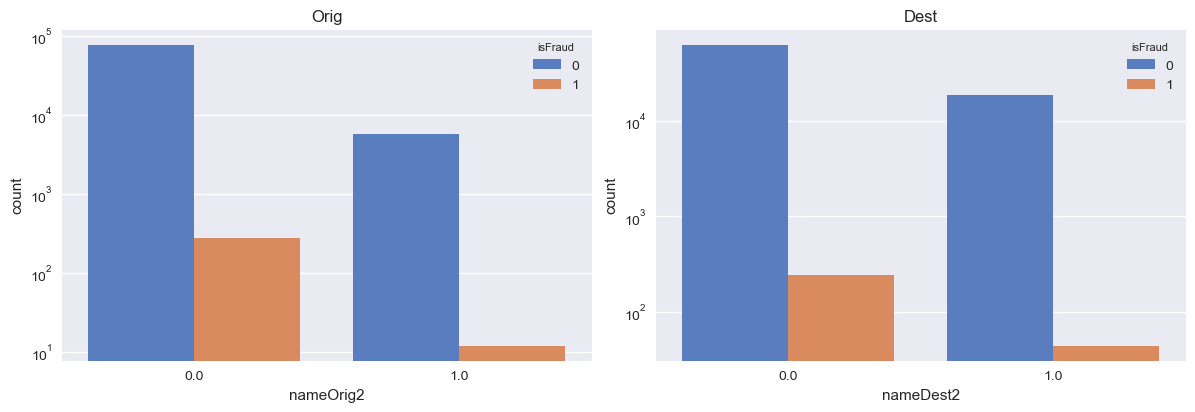

In [61]:
fig = plt.figure()
fig.set_size_inches(12, 4)
ax_1 = fig.add_subplot(1, 2, 1)
sns.countplot(data=filtered_df_Amt, 
              x='nameOrig2', 
              hue='isFraud',
              palette= "muted").set_yscale('log')

ax_2 = fig.add_subplot(1, 2, 2)
sns.countplot(data=filtered_df_Amt, 
              x='nameDest2', 
              hue='isFraud',
              palette= "muted").set_yscale('log')
fig.tight_layout()
ax_1.set(title = 'Orig')
ax_2.set(title = 'Dest')
plt.show()

Text(0.5, 1.0, 'Correlation Matrix for Cars')

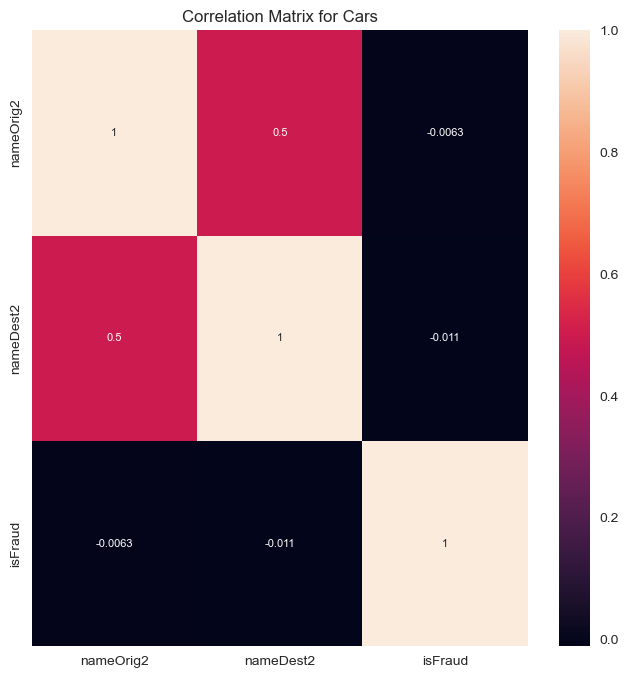

In [24]:
# Correlations between A1 variables can be checked since we have scales
df_num=filtered_df_Amt.loc[:, ("nameOrig2","nameDest2",'isFraud')]
# df_num.sample(5)
# print(df_num.corr())

# # Use Seaborn to plot a correlation heat map
plt.rcParams['figure.figsize'] = (8, 8)
plt.rcParams['font.size'] = 8
sns.heatmap(df_num.corr(),annot=True)
# sns.heatmap(df_num.corr(),annot=True, cmap="crest")
plt.title("Correlation Matrix for Cars")

#### <font color='#4682B4'> Note </font>
A 0.5 correlation indicates a moderate positive relationship. 
While not very strong, it may suggest the feature explains some of the variance in the dependent variable.

### <font color='BLUE'> 3. Assess the relevance of numerical values </font>

In [41]:
# Create time metrics
filtered_df_Amt_=filtered_df_Amt.copy()
filtered_df_Amt_['day_of_month'] = [math.floor(step/24) for step in filtered_df_Amt['step']] 
filtered_df_Amt_['hour_within_day'] = filtered_df_Amt['step'] % 24

del filtered_df_Amt
filtered_df_Amt=filtered_df_Amt_
filtered_df_Amt.sample(10)

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,day_of_month,hour_within_day
4353231,309,CASH_OUT,4875.44,C995265860,0.00,0.00,C1232826228,212993.98,217869.43,0,0,12,21
3501372,259,CASH_OUT,4789.39,C1366548319,0.00,0.00,C2046694028,147971.54,152760.93,0,0,10,19
1557133,154,CASH_OUT,4589.01,C339507862,305.00,0.00,C1709999815,675415.57,680004.57,0,0,6,10
2291425,187,CASH_OUT,3274.26,C549264777,404.00,0.00,C271095768,8998093.48,9294645.30,0,0,7,19
3884387,283,CASH_OUT,7000.25,C932482405,7176.45,176.20,C1575356440,38859.72,45859.97,0,0,11,19
4521858,326,CASH_OUT,1959.14,C1277583820,100232.00,98272.86,C754116828,0.00,1959.14,0,0,13,14
1587576,155,CASH_OUT,1326.36,C869045759,0.00,0.00,C754870753,436828.36,438154.71,0,0,6,11
5784837,400,CASH_OUT,5357.14,C373943824,15640.00,10282.86,C391312110,41805.81,47162.95,0,0,16,16
1476468,141,CASH_OUT,5008.06,C103512125,5032.00,23.94,C1047971035,517963.42,522971.48,0,0,5,21
4275799,307,CASH_OUT,1392.05,C811297406,31128.00,29735.95,C1019086689,1534594.65,1535986.70,0,0,12,19


C:\Users\cleme\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


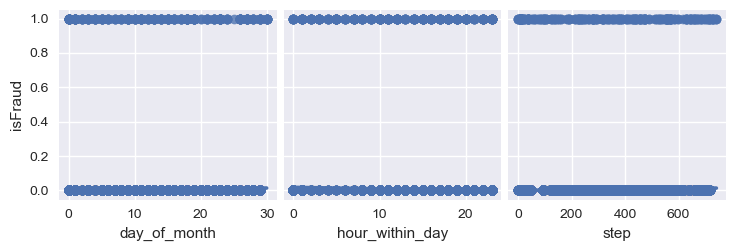

In [42]:
sns.pairplot(filtered_df_Amt, x_vars = ['day_of_month','hour_within_day',"step"], y_vars= ["isFraud"], kind = "reg")
plt.show()

#### <font color='#4682B4'> Note </font>
Both fraud and non-fraud transactions take place across the month and across the day

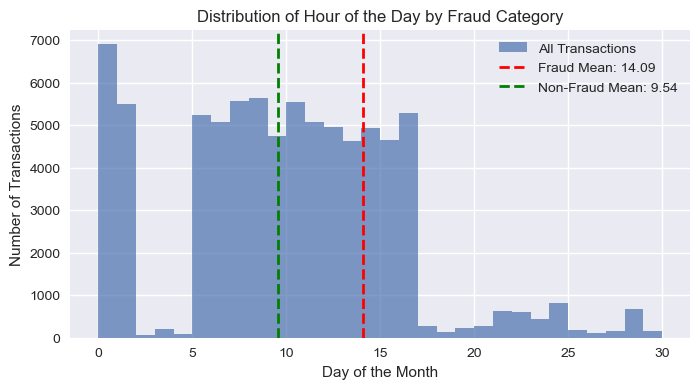

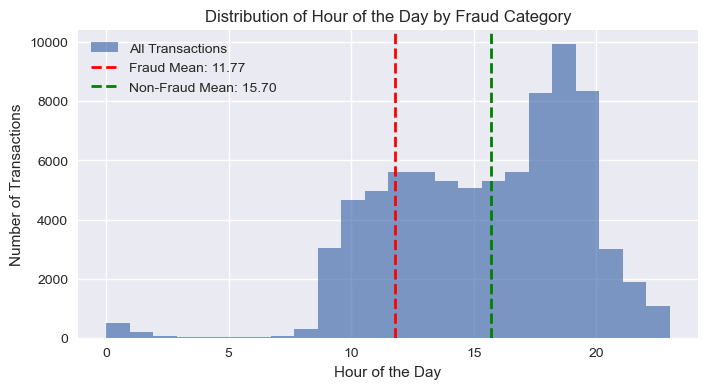

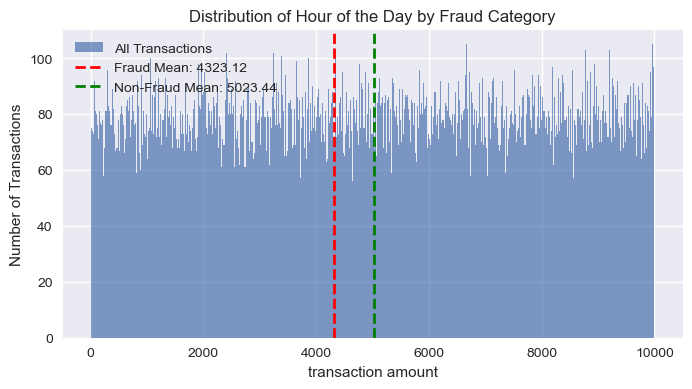

In [44]:
def histplot_eda(var, define,bin_nb):
    # Group data by fraud category and calculate means
    fraud_mean = filtered_df_Amt[filtered_df_Amt['isFraud'] == True][var].mean()
    non_fraud_mean = filtered_df_Amt[filtered_df_Amt['isFraud'] == False][var].mean()

    # Create the histogram
    plt.figure(figsize=(8, 4))  # Adjust figure size as desired
    plt.hist(filtered_df_Amt[var], bins=bin_nb, alpha=0.7, label='All Transactions')  # Adjust bins for better visualization

    # Plot vertical lines for means with labels
    plt.axvline(x=fraud_mean, color='red', linestyle='dashed', linewidth=2, label=f'Fraud Mean: {fraud_mean:.2f}')
    plt.axvline(x=non_fraud_mean, color='green', linestyle='dashed', linewidth=2, label=f'Non-Fraud Mean: {non_fraud_mean:.2f}')

    # Customize the plot
    plt.xlabel(define)
    plt.ylabel('Number of Transactions')
    plt.title('Distribution of Hour of the Day by Fraud Category')
    plt.legend()
    plt.grid(True)
    plt.show()
    
histplot_eda('day_of_month','Day of the Month',30)   
histplot_eda('hour_within_day','Hour of the Day',24)   
histplot_eda('amount','transaction amount',1000)   

#### <font color='#4682B4'> Note </font>
Fraudulent transactions tend to occur later in the month on average and later in the day (around 3 PM instead of midday). They also tend to involve slightly smaller amounts. All criteria are put in place to try to make them unnoticed!

Text(0.5, 1.0, 'Correlation Matrix for Cars')

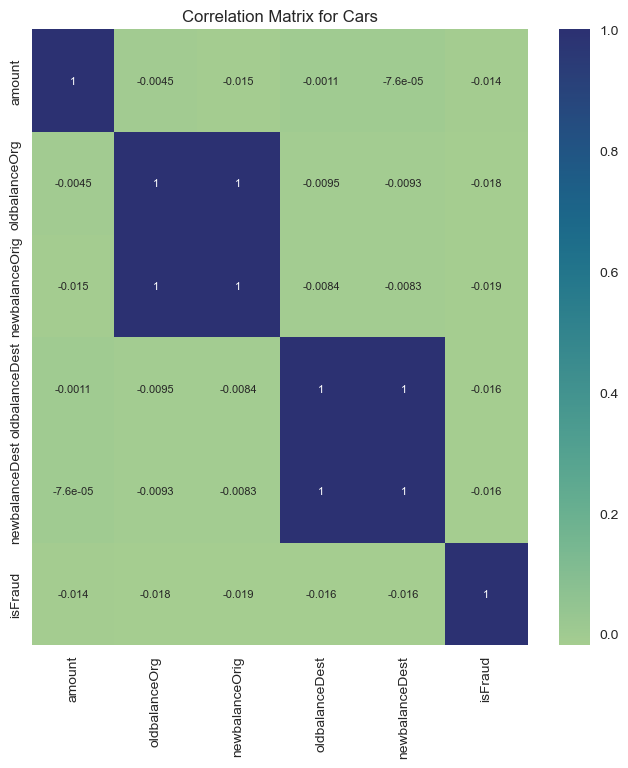

In [49]:
# Correlations between A1 variables can be checked since we have scales
df_num=filtered_df_Amt.loc[:, ("amount","oldbalanceOrg","newbalanceOrig","oldbalanceDest","newbalanceDest",'isFraud')]
# df_num.sample(5)
# print(df_num.corr())

# # Use Seaborn to plot a correlation heat map
plt.rcParams['figure.figsize'] = (8, 8)
plt.rcParams['font.size'] = 8
sns.heatmap(df_num.corr(),annot=True, cmap="crest")
plt.title("Correlation Matrix for Cars")

#### <font color='#4682B4'> Note </font>
Old and New balance origins as well as Old and New balance destintations are correlated. 
Only one of those metrics should be seleceted in each pair

### <font color='BLUE'> 4. Choose the relevant model </font>

#### <font color='BLUE'> 4.1 Keep variables deemed relevant in the EDA phase </font>

In [25]:
df_Models=filtered_df_Amt.drop(columns=['step','oldbalanceOrg','oldbalanceDest','isFlaggedFraud','nameOrig','nameDest'])
df_Models.sample(5)

,type,amount,newbalanceOrig,newbalanceDest,isFraud,nameDest2,nameOrig2
81276,TRANSFER,1707.40,0.00,0.00,1,0.0,0.0
75981,CASH_OUT,7987.11,244198.89,7987.11,0,0.0,0.0
36909,CASH_OUT,7155.13,0.00,7155.13,0,0.0,0.0
21312,CASH_OUT,6308.78,0.00,1604014.26,0,1.0,0.0
3010,CASH_OUT,2272.70,10913.64,29232.70,0,0.0,0.0


In [26]:
#start with converting categorical variables in binary ones
binary_type = pd.get_dummies(df_Models['type'], prefix='type')
df3_dummies=pd.concat([df_Models,binary_type], axis=1)

df_Models=df3_dummies.drop(columns=['type'])
del df3_dummies
df_Models.sample(5)

,amount,newbalanceOrig,newbalanceDest,isFraud,nameDest2,nameOrig2,type_CASH_OUT,type_TRANSFER
32069,442.95,0.00,915247.20,0,0.0,0.0,True,False
15169,1981.90,0.00,1889985.80,0,1.0,1.0,True,False
34956,1719.91,104455.09,7329158.50,0,0.0,0.0,True,False
16845,3954.12,0.00,193277.58,0,0.0,0.0,True,False
60826,8400.27,13243.73,8400.27,0,0.0,0.0,True,False


#### <font color='BLUE'> 4.2. Logistic Regression </font>

In [120]:
X=df_Models.drop(columns=['isFraud'])
Y=df_Models["isFraud"]

#Train test split
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X,Y,test_size=.30, random_state=42)

##Import
from sklearn.linear_model import LogisticRegression

#Instantiate
lor = LogisticRegression()

#Fit the model
lor.fit(X,Y.values.ravel())

#Predict the model
Y_pred = lor.predict(X_test)

# Model quality 
print(lor.score(X, Y))


from sklearn.metrics import classification_report,confusion_matrix
# # print(classification_report(Y_test, Y_pred))

# from sklearn.metrics import precision_score, recall_score, f1_score
# precision = precision_score(Y_test, Y_pred, zero_division=0)  # or zero_division=1
# recall = recall_score(Y_test, Y_pred, zero_division=0)
# f1 = f1_score(Y_test, Y_pred, zero_division=0)
print(classification_report(Y_test, Y_pred, zero_division=0))

print(np.exp(lor.coef_))
print(X_test.columns)

0.996294901541564
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     24609
           1       0.00      0.00      0.00        87

    accuracy                           1.00     24696
   macro avg       0.50      0.50      0.50     24696
weighted avg       0.99      1.00      0.99     24696

[[0.99973791 0.01812752 0.99999907 1.05048797 0.75024165 0.99161907
  0.99683776 0.97040129 1.00948347]]
Index(['amount', 'newbalanceOrig', 'newbalanceDest', 'day_of_month',
       'hour_within_day', 'nameDest2', 'nameOrig2', 'type_CASH_OUT',
       'type_TRANSFER'],
      dtype='object')


In [121]:
coefficients = lor.coef_[0]
feature_names = X.columns.tolist()
feature_coefficients = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': coefficients
})

# Set display options
pd.set_option('display.float_format', lambda x: '%.6f' % x)
# Sort by absolute value of coefficients
feature_coefficients = feature_coefficients.reindex(feature_coefficients.Coefficient.abs().sort_values(ascending=False).index)

# Display the table
print(feature_coefficients)

           Feature  Coefficient
1   newbalanceOrig    -4.010324
4  hour_within_day    -0.287360
3     day_of_month     0.049255
7    type_CASH_OUT    -0.030046
8    type_TRANSFER     0.009439
5        nameDest2    -0.008416
6        nameOrig2    -0.003167
0           amount    -0.000262
2   newbalanceDest    -0.000001


#### <font color='BLUE'> 4.3. Logistic Regression with better balanced data </font>

In [27]:
df_Models_balanced=pd.concat([df_Models[df_Models["isFraud"]==1],df_Models[df_Models["isFraud"]==0].sample(300)], axis=0)

In [28]:
X=df_Models_balanced.drop(columns=['isFraud'])
Y=df_Models_balanced["isFraud"]

#Train test split
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X,Y,test_size=.30, random_state=42)

##Import
from sklearn.linear_model import LogisticRegression

#Instantiate
lor = LogisticRegression()

#Fit the model
lor.fit(X,Y.values.ravel())

#Predict the model
Y_pred = lor.predict(X_test)

# Model quality 
accuracy=lor.score(X, Y)
print("Accuracy of the training dataset: {:.2f}".format(accuracy))


from sklearn.metrics import classification_report,confusion_matrix
print(classification_report(Y_test, Y_pred, zero_division=0))

coefficients = lor.coef_[0]
feature_names = X.columns.tolist()
feature_coefficients = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': coefficients
})

# Set display options
pd.set_option('display.float_format', lambda x: '%.6f' % x)
# Sort by absolute value of coefficients
feature_coefficients = feature_coefficients.reindex(feature_coefficients.Coefficient.abs().sort_values(ascending=False).index)

# Display the table
print(feature_coefficients)

Accuracy of the training dataset: 0.70
              precision    recall  f1-score   support

           0       0.78      0.51      0.61        83
           1       0.66      0.87      0.75        93

    accuracy                           0.70       176
   macro avg       0.72      0.69      0.68       176
weighted avg       0.72      0.70      0.69       176

          Feature  Coefficient
1  newbalanceOrig    -0.768367
6   type_TRANSFER     0.005580
5   type_CASH_OUT    -0.002236
4       nameOrig2    -0.000340
3       nameDest2    -0.000152
0          amount     0.000072
2  newbalanceDest    -0.000000


#### <font color='#4682B4'> Note </font>
We select the model were we chose 500 non fraud transactions randomly as it has a good recall and f1-score.
Another important point is that it takes into account more variables, there is less of an over-reliance on newbalanceOrig.

#### <font color='#4682B4'> Outputs with 300 non Fraud transactions: </font>
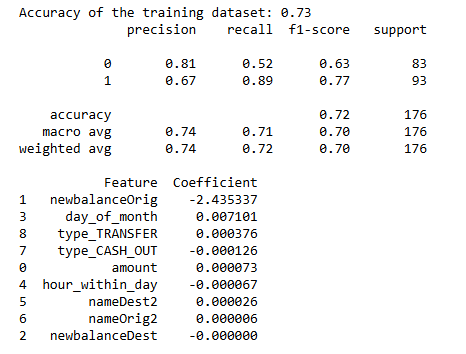

#### <font color='#4682B4'> Outputs with 500 non Fraud transactions: </font>
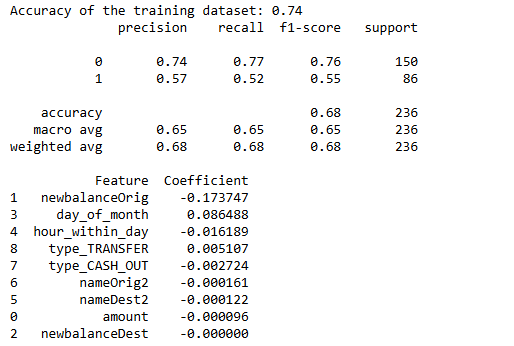

#### <font color='#4682B4'> Outputs with 1000 non Fraud transactions: </font>
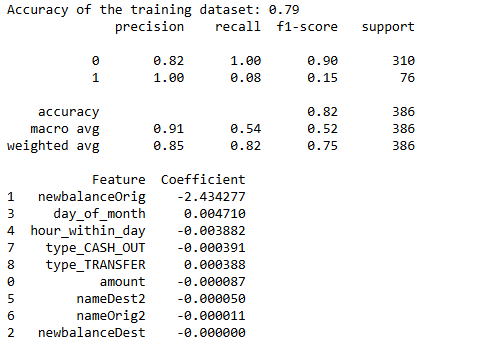


#### <font color='BLUE'> 4.4. Decision Tree </font>

In [150]:
df_Models_balanced=pd.concat([df_Models[df_Models["isFraud"]==1],df_Models[df_Models["isFraud"]==0].sample(300)], axis=0)

In [151]:
X1=df_Models_balanced.drop(columns=['isFraud'])
Y1=df_Models_balanced["isFraud"]

#Train test split
from sklearn.model_selection import train_test_split
X1_train, X1_test, Y1_train, Y1_test = train_test_split(X1,Y1,test_size=.30, random_state=42)

##Import
from sklearn.tree import DecisionTreeClassifier

##Instantiate
dtree1 = DecisionTreeClassifier()

#Fit
dtree1.fit(X1_train, Y1_train)

#predict
Y1_pred=dtree1.predict(X1_test)
from sklearn.metrics import classification_report, confusion_matrix
print(confusion_matrix(Y1_test, Y1_pred))
print(classification_report(Y1_test,Y1_pred))

[[73 10]
 [12 81]]
              precision    recall  f1-score   support

           0       0.86      0.88      0.87        83
           1       0.89      0.87      0.88        93

    accuracy                           0.88       176
   macro avg       0.87      0.88      0.87       176
weighted avg       0.88      0.88      0.88       176



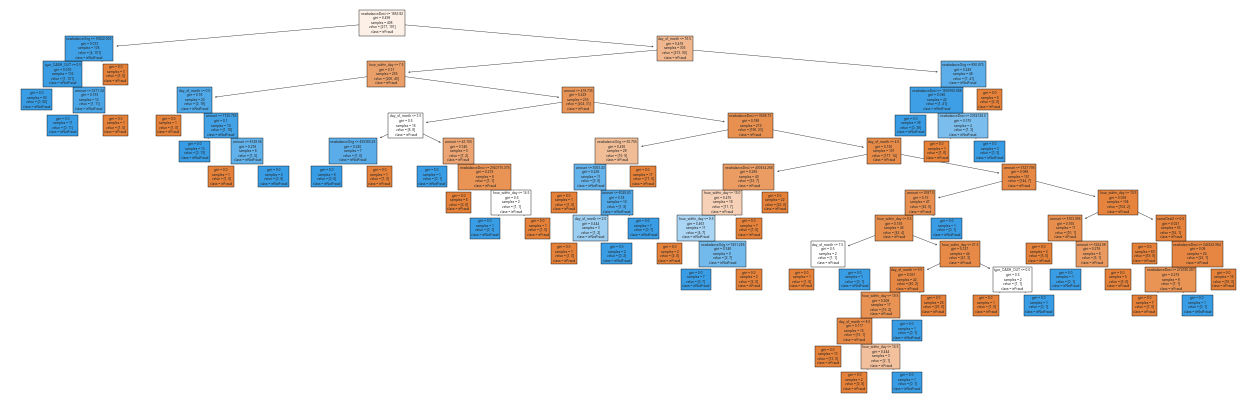

In [152]:
from sklearn.tree import plot_tree

plt.figure(figsize=(16,5))
plot_tree(dtree1, filled = True, feature_names=["amount", "newbalanceOrig", "newbalanceDest", "day_of_month", "hour_within_day", "nameDest2", "nameOrig2", "type_CASH_OUT", "type_TRANSFER", "type_CASH_OUT", "type_TRANSFER"], class_names=["isFraud", "isNotFraud"])
plt.show()

In [165]:
importances = dtree1.feature_importances_
feature_names = X1.columns.tolist()

# Create a DataFrame for feature importances
feature_importances = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
})

# Sort by importance
feature_importances = feature_importances.sort_values(by='Importance', ascending=False)

# Display the table
print(feature_importances)

           Feature  Importance
2   newbalanceDest    0.391601
3     day_of_month    0.218974
4  hour_within_day    0.161444
1   newbalanceOrig    0.145137
0           amount    0.076894
7    type_CASH_OUT    0.005646
5        nameDest2    0.000304
6        nameOrig2    0.000000
8    type_TRANSFER    0.000000


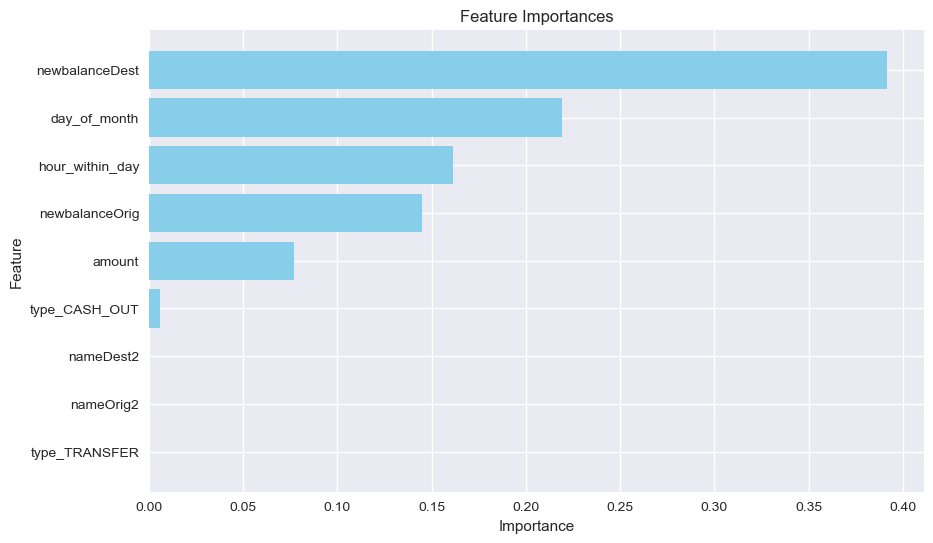

In [166]:
import matplotlib.pyplot as plt

# Plot the feature importances
plt.figure(figsize=(10, 6))
plt.barh(feature_importances['Feature'], feature_importances['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importances')
plt.gca().invert_yaxis()
plt.show()

#### <font color='#4682B4'> Note </font>
The Decision Tree is showing much better results while taking into account the range input variables

In [155]:
# visual
from sklearn.tree import export_text

r = export_text(dtree1, feature_names=X.columns)
print(r)

|--- newbalanceDest <= 1853.82
|   |--- newbalanceOrig <= 10822.00
|   |   |--- type_CASH_OUT <= 0.50
|   |   |   |--- class: 1
|   |   |--- type_CASH_OUT >  0.50
|   |   |   |--- amount <= 3371.34
|   |   |   |   |--- class: 1
|   |   |   |--- amount >  3371.34
|   |   |   |   |--- class: 0
|   |--- newbalanceOrig >  10822.00
|   |   |--- class: 0
|--- newbalanceDest >  1853.82
|   |--- day_of_month <= 16.50
|   |   |--- hour_within_day <= 7.50
|   |   |   |--- day_of_month <= 0.50
|   |   |   |   |--- class: 0
|   |   |   |--- day_of_month >  0.50
|   |   |   |   |--- amount <= 7725.77
|   |   |   |   |   |--- class: 1
|   |   |   |   |--- amount >  7725.77
|   |   |   |   |   |--- amount <= 8149.56
|   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |--- amount >  8149.56
|   |   |   |   |   |   |--- class: 1
|   |   |--- hour_within_day >  7.50
|   |   |   |--- amount <= 418.74
|   |   |   |   |--- day_of_month <= 3.50
|   |   |   |   |   |--- newbalanceOrig <= 435365.25
|   

#### <font color='BLUE'> 4.4. Random Forest </font>

In [157]:
X2=df_Models_balanced.drop(columns=['isFraud'])
Y2=df_Models_balanced["isFraud"]

#Train test split
from sklearn.model_selection import train_test_split
X2_train, X2_test, Y2_train, Y2_test = train_test_split(X2,Y2,test_size=.30, random_state=42)

#import 
from sklearn.ensemble import RandomForestClassifier

#instantiate
rfc = RandomForestClassifier(n_estimators=100)

#fit
rfc.fit(X2_train, Y2_train)

#predict
Y2_pred=rfc.predict(X2_test)

from sklearn.metrics import classification_report, confusion_matrix
print(confusion_matrix(Y2_test, Y2_pred))
print(classification_report(Y2_test,Y2_pred))

[[78  5]
 [10 83]]
              precision    recall  f1-score   support

           0       0.89      0.94      0.91        83
           1       0.94      0.89      0.92        93

    accuracy                           0.91       176
   macro avg       0.91      0.92      0.91       176
weighted avg       0.92      0.91      0.91       176



#### <font color='#4682B4'> Note </font>
The Random Forest is showing much better results while taking into account the range input variables

In [163]:
importances = rfc.feature_importances_
feature_names = X2.columns.tolist()

# Create a DataFrame for feature importances
feature_importances = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
})

# Sort by importance
feature_importances_RF = feature_importances.sort_values(by='Importance', ascending=False)

# Display the table
print(feature_importances)

           Feature  Importance
0           amount    0.099102
1   newbalanceOrig    0.143152
2   newbalanceDest    0.299670
3     day_of_month    0.210878
4  hour_within_day    0.156124
5        nameDest2    0.007975
6        nameOrig2    0.003029
7    type_CASH_OUT    0.038242
8    type_TRANSFER    0.041827


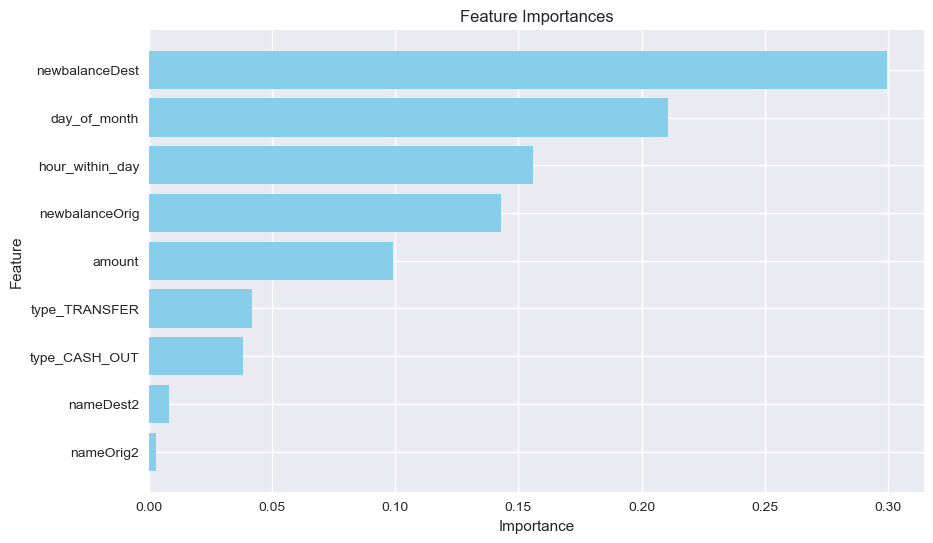

In [164]:
import matplotlib.pyplot as plt

# Plot the feature importances
plt.figure(figsize=(10, 6))
plt.barh(feature_importances_RF['Feature'], feature_importances_RF['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importances')
plt.gca().invert_yaxis()
plt.show()

## <font color='BLUE'> Conclusion </font>
The Random Forest is the best model to tackle fraud as it takes into account a variety of input variables, making it robust. It also performs best on the overall precision and recall indicators for Fraud.

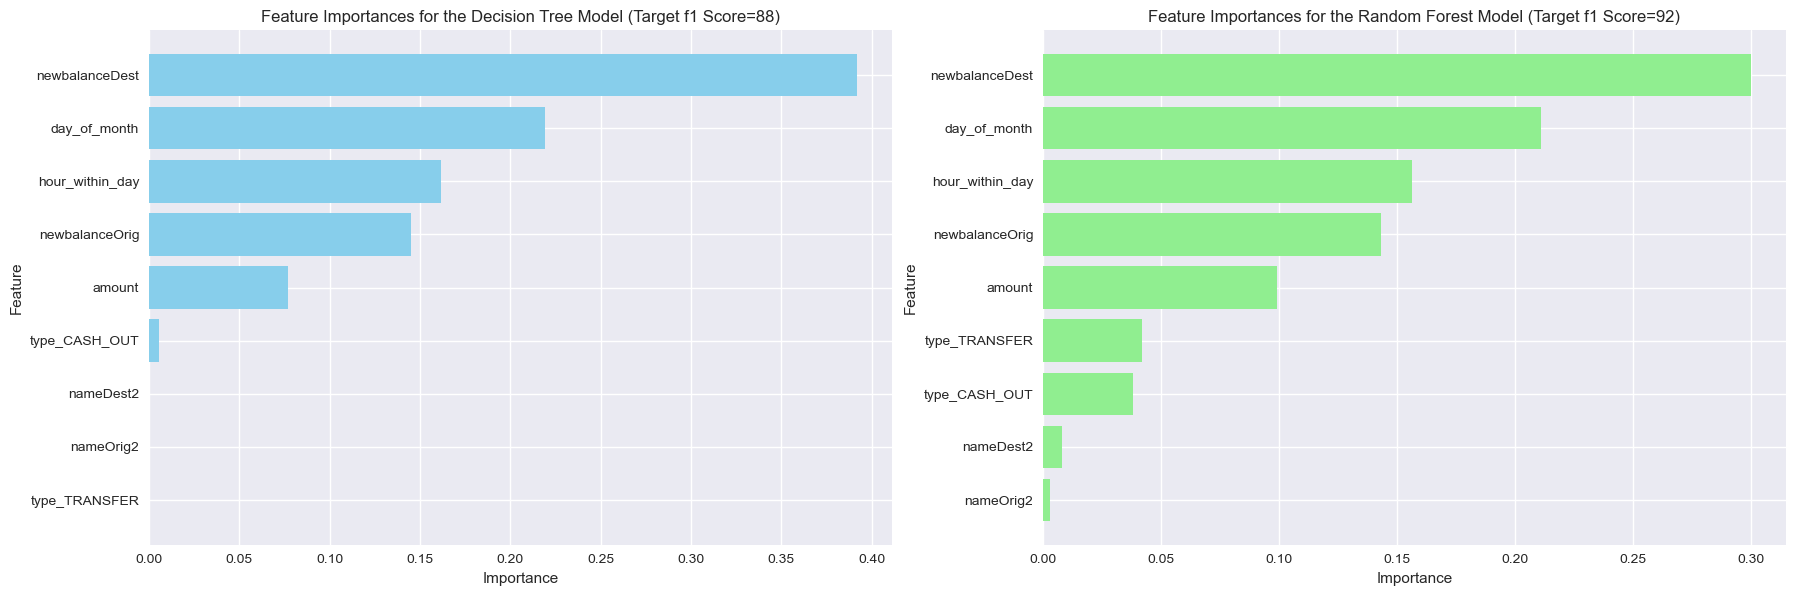

In [184]:
# Define the size of the figure and subplots
plt.figure(figsize=(18, 6))

# Plotting the second chart (right subplot)
plt.subplot(1, 2, 1)  # 1 row, 2 columns, 2nd subplot
plt.barh(feature_importances['Feature'], feature_importances['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importances for the Decision Tree Model (Target f1 Score=88)')
plt.gca().invert_yaxis()

# Plotting the first chart (left subplot)
plt.subplot(1, 2, 2)  # 1 row, 2 columns, 1st subplot
plt.barh(feature_importances_RF['Feature'], feature_importances_RF['Importance'], color='lightgreen')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importances for the Random Forest Model (Target f1 Score=92)')
plt.gca().invert_yaxis()

# Adjust layout to prevent overlap
plt.tight_layout()

# Display the plots
plt.show()
